# Machine Learning for Fluid Property Correlation with Python

by Nikolas Ferber, handed in on January 23, 2022

____________________________

This notebook seeks to broadly reproduce the findings of the article *Machine Learning for Fluid Property Correlations: Classroom Examples with MATLAB*[1], but using Python with the libraries scikit-learn[2] and PyTorch[3] instead of MATLAB. We will additionally use the libraries Numpy[4] and Pandas[5][6] for handling large datasets and Matplotlib[7] for visualization.

The aim is to find predictions for the boiling points of organic chemical compounds from a data set of more than 6000 such compounds, using correlated properties. In the first section we will use univariate and then multivariate linear regression for this purpose, after that we will use PyTorch to set up an artificial neural network that can produce more accurate predictions.



In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

## Introduction

________________________

### Data

The data set[8] used here includes the names, boiling point, molecular weight, critical temperature, and acentric factor of more than 6000 mostly organic compounds. The data was compiled from various sources, not all of them necessarily reliable, and additionally inludes some nonorganic compounds[1]. These factors may make predicting the boiling points more difficult than a more strictly curated dataset, but we will use it as it is here.

In [7]:
# df = pd.read_excel('JossM2019_boiling_dataset.xlsx', header=0)
df = pd.read_csv('JossM2019_boiling_dataset.csv', header=0, sep=';') ## KNK
df.drop(columns='id', inplace=True)
df

,name,molweight,critical temperature (K),acentric factor,boiling point (K)
0,(+)-a-pinene,136.23704,647.00,0.3410,428.65
1,(+)-camphene,136.23704,638.00,0.2960,432.65
2,(-)-a-pinene,136.23704,647.00,0.3410,429.35
3,(-)-b-citronellol,156.26820,656.59,0.6120,498.65
4,(-)-camphene,136.23704,638.00,0.2960,439.95
...,...,...,...,...,...
6026,water,18.01528,647.13,0.3449,373.15
6027,xylenes,106.16740,620.21,0.3170,413.15
6028,zirconium bromide,410.84000,805.00,0.3100,633.15
6029,zirconium chloride,233.03480,778.00,0.2980,604.15


### Training and testing datasets

Before we begin creating models that predict the boiling points of these compounds, we need to find a way to then evaluate how accurately the predictions of those models actually are. If we used the entire available dataset to create our model, that might provide us with the most accurate models for calculating these prediction. However, doing that would mean that during the creation of the model, it would have "seen" all the data available to us, leaving us without any leftover data that we could use to accurately test the model with data that it doesn't already know.

To avoid this issue, we split the data into separate *training* and *testing data sets*. Only the training set will be used to create the prediction model, leaving us with the testing set as data that the model has never seen before, so it can be used to accurately evaluate the quality of the model's predictions.

### Exploring potential correlations

A first reasonable guess for how to help estimate a compound's boiling point is that it might correlate with the weight of its molecules. To explore this possibility, we start by showing their relationship in the given dataset using Matplotlib:

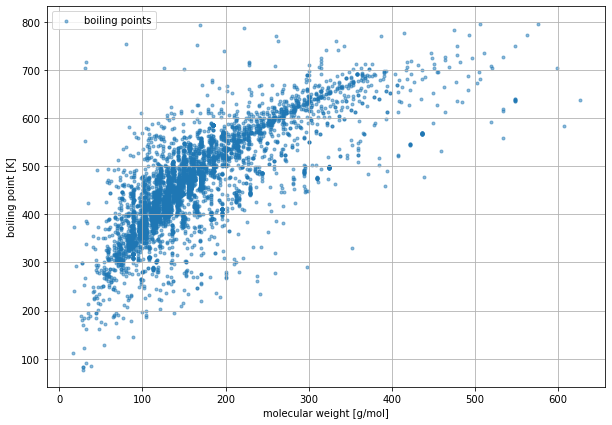

In [8]:
mol_weight = df['molweight'].to_numpy().reshape(-1, 1)
critical_temp = df['critical temperature (K)'].to_numpy().reshape(-1, 1)
acentric_factor = df['acentric factor'].to_numpy().reshape(-1, 1)
boiling_point = df['boiling point (K)'].to_numpy().reshape(-1, 1)

plt.figure(figsize=(10,7))
plt.scatter(x=mol_weight, y=boiling_point,
            label='boiling points',
            marker='.', alpha=0.5)

plt.xlabel(xlabel='molecular weight [g/mol]')
plt.ylabel(ylabel='boiling point [K]')
plt.grid()
plt.legend()
plt.show()

Here we can see a clear correlation between these two properties. We can also see that a simple linear function fit to this data might provide us with a decent first model for predicting boiling points based on just the molecular weight, leading us into the first machine learning topic presented here, *linear regression*.

## Linear Regression

_________________

Linear regression is a comparatively simple approach at predicting numerical properties based on one or more features by trying to find the best fitting linear function for the given dataset. Inputting features of, in this case, an additional organic compound will then provide a rough estimate for that compound's boiling point.

Before starting on the calculations, we will use scikit-learn's method `train_test_split` to split the data into randomized separate sets for training and testing:

In [9]:
mw_train, mw_test, ct_train, ct_test, af_train, af_test, bp_train, bp_test = train_test_split(
    mol_weight, critical_temp, acentric_factor, boiling_point, train_size=0.04)

### Univariate linear regression

Based on our observations above, we will first try predicting the boiling points using just one variable, the molecular weight of the compounds. Using scikit-learn, we can easily create a univariate linear regression model for this purpose and fit it to our training dataset:

In [10]:
reg = linear_model.LinearRegression()
model = reg.fit(X=mw_train, y=bp_train)

Now we can calculate and show a prediction for the boiling points of compounds in the *testing set* based on this fit:

In [11]:
prediction = model.predict(X=mw_test)
prediction

array([[406.74697534],
       [390.51962552],
       [707.20744602],
       ...,
       [450.6387407 ],
       [515.36227798],
       [441.92749729]])

To verify how accurately this prediction fits the data, we calculate the R² value with scikit-learn. For the sake of brevity we will not explain the details of R² value calculation here. Important to know here is primarily that R² can be used as a measure of a prediction's accuracy, where the closer the value is to 1, the better the prediction is.

In [12]:
r2_score(y_true=bp_test, y_pred=prediction)

0.5563275572672848

This value for R² suggests that there is a correlation between a compound's molecular weight and its boiling point. While the accuracy of predictions can still be improved significantly with more complex models and taking other features of the molecules into account, this score can serve as a good baseline to compare other models against.

Visualizing the fit from the linear regression model with Matplotlib, we get the following graph. We can use it to verify that for a linear fit, scikit-learn's linear regression model managed to fit the data well.

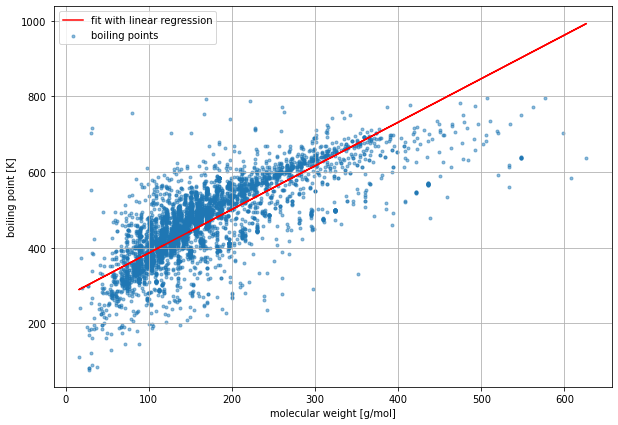

In [13]:
plt.figure(figsize=(10,7))
plt.scatter(x=mol_weight, y=boiling_point,
            label='boiling points',
            marker='.', alpha=0.5)
plt.plot(mw_test, prediction,
         label='fit with linear regression',
         color='red')

plt.xlabel(xlabel='molecular weight [g/mol]')
plt.ylabel(ylabel='boiling point [K]')
plt.grid()
plt.legend()
plt.show()

### Multivariate Linear Regression

The previous prediction only used one feature as input data. We can try to increase the precision of our prediction by taking more features into account. For this purpose we will first try using multivariate linear regression. As features we will use the molecular weight like we did before and additionally include the acentric factor, a unitless measure that describes aspects of the shape of molecules.

To do this with scikit-learn, we need to put both features for all the molecules in matrix form and then use that as input for the model:

In [14]:
train_matrix = np.hstack((mw_train, af_train))
test_matrix = np.hstack((mw_test, af_test))

model = reg.fit(X=train_matrix, y=bp_train)

As we did above, we can now use this model to create a prediction for our testing data:

In [15]:
prediction = model.predict(X=test_matrix)
prediction

array([[387.22824819],
       [396.29009165],
       [726.29580776],
       ...,
       [434.96041507],
       [520.57129367],
       [440.20585679]])

Now we will again use the R² score to verify how accurately our new prediction fits the data:

In [16]:
r2_score(y_true=bp_test, y_pred=prediction)

0.7070542592016138

This is a significant improvement over the univariate model, showing that the acentric factor is related to the boiling point of compounds and that we can use the addition of the acentric factor in our models to increase their precision.

#### Potential adjustments to model creation

Initially we used only 4% of the full data set to train the linear regression model, now we will quickly explore how our results change if we use drastically more data to create the model, increasing the share of training data to 15%:

In [17]:
mw_train, mw_test, ct_train, ct_test, af_train, af_test, bp_train, bp_test = train_test_split(
    mol_weight, critical_temp, acentric_factor, boiling_point, train_size=0.15)

In [18]:
train_matrix = np.hstack((mw_train, af_train))
test_matrix = np.hstack((mw_test, af_test))

model = reg.fit(X=train_matrix, y=bp_train)

prediction = model.predict(X=test_matrix)

r2_score(y_true=bp_test, y_pred=prediction)

0.7136474730890363

Depending on the random selection from the training data, this score will usually be only around 1% bigger or smaller than the result with the smaller training data set, so they can be considered essentially equal.

This tells us that the linear regression model works well even with a relatively small set of training data and remains quite stable for different training data sizes.

Lastly, we will try using the ratio of boiling point to critical temperature instead of the absolute boiling point. This has two advantages, firstly putting more theoretical insight into the model, as this ratio could be considered more meaningful in this context than using the boiling point alone. Additionally, it regularizes the data as thís ratio lies between 0 and 1 for all compounds, which comes with some numerical benefits, avoiding potential problems with calculations involving numbers of very different orders of magnitude.[1]

In [19]:
bp_rel_train = bp_train / ct_train
bp_rel_test = bp_test / ct_test

model = reg.fit(X=train_matrix, y=bp_rel_train)
predict_rel = model.predict(X=test_matrix)
predict_rel

array([[0.75438822],
       [0.61883537],
       [0.75077064],
       ...,
       [0.65571658],
       [0.68573694],
       [0.71035157]])

In [20]:
r2_score(y_true=bp_rel_test, y_pred=predict_rel)

0.7087604152101441

This change does not seem to give us a notably better score, so it looks like it does not meaningfully improve our prediction with the linear regression model. Artificial neural network algorithms tend to work better with values between 0 and 1 though[1], so we will use these relative values in the next section.

## Artificial Neural Networks

________________________

### Introduction

In this section we will construct an artificial neural network to try to create a model that gives us more accurate predictions than linear regression.

Artificial neural networks (ANNs) are systems of nodes, called neurons, that are set up between the input and output nodes and act as functions of the input variables with adjustable parameters called weights and biases. They pass their results along to nodes in layers behind them, ultimately leading into a final node that gives us our prediction for the given input values.

What makes ANNs useful is that they can be used in various cases where the nature of the relationship between input and output data is unclear or difficult to manually calculate. This is because they can be constructed to be as complex as needed for any given task and because they can "learn" automatically. The weights and biases of all neurons in an ANN can initially be set up randomly, not requiring any initial estimate by a researcher. Training data is then put into the ANN and results are compared to the actual target output values. Based on how much and in which direction the prediction deviated from the target values, all the weights and biases can then be updated to try to increase the precision of the prediction. This process can, depending on the size of the training dataset and the complexity of the ANN, quickly be repeated hundreds or thousands of times to gradually increase precision and eventually create a very accurate final model.

The two main types of problems ANNs are used for are *classification* and *regression*.

- In *classification* problems, ANNs should decide which of a predefined set of categories the given input belongs in. A major example for this is image recognition, where the input is an image and the output can e.g. be "road", "car", or "pedestrian."

- In *regression* problems, the ANN takes input values and outputs a single numerical value as a result, so the prediction of boiling points of chemical compounds is a regression problem.

![ANN graph](neural_net.svg)

#### Building the ANN structure

Above is an image illustrating the shape of the ANN we will create. As we did earlier for multivariate linear regression, we will use two features as input variables, the molecular weight and the acentric factor.

Those values will be passed into the first so-called *hidden layer* of the ANN. We use linear layers here, meaning the functions in the nodes on the left of the first hidden layer have the shape

$f_{i}(m, a) = w_{i,1}\cdot m + w_{i,2}\cdot a + b_{i}$,

where $m$ is the molecular weight, $a$ the acentric factor, $w_{i,j}$ are the weights and $b_{i}$ the biases.

To introduce nonlinearity, their results are then passed through the function $tanh(x) = \frac{2}{1+e^{-2x}} - 1$.

After that, they are relayed into the second hidden layer of the ANN. This layer is set up analogously to the first layer, with the difference that the linear nodes take the output of all the nodes in the previous layer as their input.

Finally, the outputs of the second hidden layer are channeled into a final linear node on the right, then passed through a sigmoid function $\sigma(x) = \frac{1}{1+e^{-x}}$ as a final nonlinear step and to normalize the result into the desired range between $0$ and $1$. The normalization is not technically necessary here, the results would end up between $1$ and $0$ after a few training loops regardless, but this setup produced slightly better results on average.

![nonlinear functions](nonlin_functions.png)

*graphs created using https://www.wolframalpha.com*

#### Creating the ANN with PyTorch

Now we will create this network in Python with PyTorch (loosely based on the implementation of an ANN for a classification problem found on github[9]). First we assign the data for training and testing, though for PyTorch we need to transform our numpy matrices and arrays to tensors. Tensors function similarly to numpy but are optimized for machine learning problems, notably you can perform calculations on them using a graphics card as the processor instead of the CPU.

In [21]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

train = torch.from_numpy(train_matrix.astype(np.float32))
test = torch.from_numpy(test_matrix.astype(np.float32))

bp_train = torch.from_numpy(bp_rel_train.astype(np.float32))
bp_test = torch.from_numpy(bp_rel_test.astype(np.float32))

Here we create the ANN structure as laid out above. In the constructor `__init__`, we define the type of functions the ANN should use. Then in the method `forward`, we define the path the input values have to pass through in the ANN.

In [22]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.tanh(out)
        out = self.l2(out)
        out = self.tanh(out)
        out = self.l3(out)
        out = self.sigmoid(out)
        return out

Now we can initialize the model. `input_size` here is the number of features or input values, which has to be 2 for our purposes.
`hidden_size` defines the number of nodes in the two hidden layers. A size of 20 in testing gave good and consistent results without taking long for calculations, but this can easily be adjusted and experimented with.

In [23]:
input_size = 2
hidden_size = 20

model = NeuralNet(input_size, hidden_size)

Next we need to decide on which *loss function* we want to use. Loss is a measure for how far a model's predictions are from the desired results. There are various ways to quantify this, here we will use the mean squared error, defined as $$\frac{\displaystyle\sum_{i=1}^{n}(y_{i, predicted} - y_{i, actual})^2}{n}.$$ This function punishes larger deviations from the desired result much more than smaller deviations, and is the typical choice for most standard regression problems[10].

In [24]:
criterion = nn.MSELoss()

We also need to pick an *optimizer* and define its *learning rate*. Optimizers calculate how the weights and biases in the nodes of the ANN are adjusted during training. There are a variety of options, here we will choose the Adam optimizer, which is again a common choice and proved effective in testing for this ANN[11].

The *learning rate* decides how strongly the optimizer will adjust the weights and biases in each training step. For the Adam optimizer and this problem, the value of 0.002 was effective and consistent in testing.

In [25]:
learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Finally, we can now train the model with the training dataset. The number of iterations, or *epochs*, was chosen as a compromise between speed and accuracy and can be adjusted in either direction as needed.

The actual learning process relies on calculating gradients during the forward pass of the data through the ANN, then calculating the loss and using a process called backpropagation to calculate in which direction and how strongly the weights and biases in the entire network should be adjusted for the strongest positive effect on the loss function. With that information, the optimizer then takes care of those adjustments, with this process repeating in each epoch until training is complete. Unfortunately, explaining the details of these methods and the concept of gradient descent is beyond the scope of this project, but there are plenty of resources to learn more about this topic.

In [26]:
num_epochs = 8000

for epoch in range(num_epochs):
    # Forward pass, calculating gradients along the way
    output = model(train)
    loss = criterion(output, bp_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # Showing progress during calculation
    if (((epoch+1) % 3 == 0 and epoch <= 10) or
        ((epoch+1) % 33 == 0 and epoch <= 100) or
        ((epoch+1) % 333 == 0 and epoch <= 1000) or
        ((epoch+1) % 2000 == 0)):
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

print('\nTraining complete!')

Epoch [3/8000], Loss: 0.022530
Epoch [6/8000], Loss: 0.006605
Epoch [9/8000], Loss: 0.002479
Epoch [33/8000], Loss: 0.002522
Epoch [66/8000], Loss: 0.002367
Epoch [99/8000], Loss: 0.002081
Epoch [333/8000], Loss: 0.000675
Epoch [666/8000], Loss: 0.000591
Epoch [999/8000], Loss: 0.000546
Epoch [2000/8000], Loss: 0.000526
Epoch [4000/8000], Loss: 0.000520
Epoch [6000/8000], Loss: 0.000521
Epoch [8000/8000], Loss: 0.000503

Training complete!


With the training complete, our model is now finished. We can now use it to predict the boiling points for all molecules in our testing data and verify how accurate it is.

In [27]:
# For testing, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    output = model(test)
    print(r2_score(y_true=bp_test, y_pred=output))

0.7872944990324738


The R² score here varies depending on the random choice of training and testing data and on the random initialization of the weights and biases in the ANN, but in testing usually gave results between 0.77 and 0.79. While still not close to a perfect prediction, this is a significantly better result than multivariate linear regression. A theoretical perfect score of 1 is also unachievable in practice with just this input data regardless of the choice of model, as the boiling point of molecules depends on more than just the features we used for these predictions.

## Conclusion

_______________

Compared to the research paper that we attempted to reproduce here, our results, while still significant, were somewhat worse than those in the paper for both multivariate linear regression and the artificial neural network, despite much experimentation with all the parameters used above such as the share of training data or various aspects of the ANN. This is not necessarily particularly surprising for the artificial neural network, as it had to be set up with more manual work compared to the ANN creation in MATLAB, which can be set up very easily and presumably comes with sensible default settings including e.g. a gradual adjustment of the learning rate, which was not used here. Probably most importantly, the ANN in the research paper further split the the data used for training the model into a training and a validation set, allowing it to adjust hyperparameters to improve the learning process and increase accuracy (explained in slightly more detail in the final section below), which was not done here.

However, while the cited paper got essentially the same R² score of 0.58 for univariate linear regression, the main article reported a score of 0.85 for the multivariate results for linear regression, vastly higher than the results above of around 0.71, depending on the random selection of the testing data. Linear regression is a comparatively simple process and we used the model from scikit-learn's library directly, so this difference seems difficult to explain.

One reason that could potentially explain both of these disparities is that when comparing the R² scores for multivariate regression and the ANN in the article's main text with their calculations in the attached detailed solutions, the reporting of the correlation coefficients R and the R² score seems a bit unclear at times and differs from the numbers in the main article. It seems possible that these two values were mixed up or presented unclearly, so that the scores of 0.85 for the multivariate linear regression and 0.89 for the ANN in the main article are actually the correlation coefficients R, meaning the R² scores would be around 0.72 and 0.79 respectively. If that is the case, they would practically exactly match the results obtained here.

### Closing remarks

While there is much more to learn about the theory behind ANNs and all the parts of their construction and training, this has hopefully shown how comparatively simple it can be to program an artificial neural network in Python that can produce fairly accurate predictions for scientific problems, even without necessarily needing any deep scientific understanding of the relationship between the properties used in the prediction.

## Outlook

_____________

To avoid the code and explanation becoming too complicated for readers unfamiliar with machine learning and neural networks and because calculations were fast enough for this purpose already, the neural network section was kept as simple as possible while explaining the key concepts. However, there are some ways to improve computational performance and the results of the model, which will be listed here but not explained in detail.

### Computational performance

- As briefly mentioned above, calculations for the training with tensors can be moved to GPUs. This requires just a few additional lines of code, but to keep the code clean and understandable, this was omitted here.
- In each epoch in our training loop, the entire training data was passed through the model at once. For performance improvements, notably for larger datasets or with much bigger input data for each object (such as with images), this can instead be done with smaller, randomized batches of only part of the training data.
- We simply set the number of training epochs as a constant above, for more reliable results that can also improve performance, the changes to the loss function results can instead be monitored and training stopped once improvement slows down to negligible levels.

### Improvements to the model

- What we used as training data here could be split up further into a data set used to directly train the model as we did here and additionally a validation set, which does not get passed through the ANN directly but is used to evaluate the model during training, allowing so-called *hyperparameters* to change based on that evaluation, usually significantly improving a model's predictions[12]. Additionally, the size of training, validation, and testing data can be adjusted and experimented with, in the final version of the project here we only use a set share of 15% of the full dataset for training, though during research other shares were used to attempt to improve results.
- The learning rate here was also set as a constant. For better results, it can be gradually adjusted to get smaller as the loss decreases, for more precise late adjustments to the model.
- Here we simply used our model with the weights and biases as they ended up after the final epoch. Alternatively, we could save and use those parameters from the pass with the lowest loss in the entire training process, this would most likely slightly improve results.
- The ANN used above has a specific structure called *multilayer perceptron*, where each input node is connected to all nodes of the next hidden layer, which in turn are fully connected with the next layer, and so on until the end[13]. There are different structures for ANNs that may perform better depending on their use case.

## References

______

1. Lisa Joss and Erich A. Müller, Machine Learning for Fluid Property Correlations: Classroom Examples with MATLAB, *Journal of Chemical Education* 2019 96 (4), 697-703, DOI: 10.1021/acs.jchemed.8b00692 
2. F. Pedregosa et al., 2011. Scikit-learn: Machine learning in Python. *Journal of machine learning research*, 12(Oct), pp.2825–2830
3. A. Paszke et al., 2019. PyTorch: An Imperative Style, High-Performance Deep Learning Library. In Advances in Neural Information Processing Systems 32. *Curran Associates, Inc.*, pp. 8024–8035. Available at: http://papers.neurips.cc/paper/9015-pytorch-an-imperative-style-high-performance-deep-learning-library.pdf
4. C.R. Harris, K.J. Millman, S.J. van der Walt et al. Array programming with NumPy. *Nature* 585, 357–362 (2020), https://doi.org/10.1038/s41586-020-2649-2, visited on January 15, 2022
5. The pandas development team, pandas-dev/pandas: Pandas, *Zenodo*, 2020, https://doi.org/10.5281/zenodo.3509134, visited on January 15, 2022
6. Wes McKinney, 2010, June. Data structures for statistical computing in python. *Proceedings of the 9th Python in Science Conference*, 51-56, https://doi.org/10.25080/Majora-92bf1922-00a, visited on January 15, 2022
7. J.D. Hunter, 2007. Matplotlib: A 2D Graphics Environment. *Computing in Science & Engineering*, vol. 9, no. 3, pp. 90-95, https://doi.org/10.1109/MCSE.2007.55, visited on January 15, 2022
8. Yaws, C. L. Yaws’ Critical Property Data for Chemical Engineers and Chemists; 2012−2014, http://app.knovel.com/hotlink/toc/id:kpYCPDCECD/yaws-critical-property/yaws-critical-property, retrieved November 2018 by the authors of *Machine Learning for Fluid Property Correlations: Classroom Examples with MATLAB*[1]
9. https://github.com/python-engineer/pytorchTutorial/blob/master/13_feedforward.py, retrieved on January 14, 2022
10. https://neptune.ai/blog/pytorch-loss-functions, retrieved on January 14, 2022
11. https://machinelearningknowledge.ai/pytorch-optimizers-complete-guide-for-beginner/#2_Adam_Optimizer, retrieved on January 14, 2022
12. https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7, retrieved on January 14, 2022
13. https://towardsdatascience.com/multilayer-perceptron-explained-with-a-real-life-example-and-python-code-sentiment-analysis-cb408ee93141, retrieved on January 19, 2022